### Imports

In [1]:
# import public packages
import os
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle
import scipy
import mne
import sys


from mne.time_frequency import tfr_morlet
from mne.baseline import rescale
from scipy.signal import spectrogram, hann, butter, filtfilt, hilbert
from scipy import signal, interpolate, stats
from scipy.interpolate import make_interp_spline, BSpline
from io import open
from importlib import reload

# import own functions
from utils import find_folders
import dat_preproc
import fix_annot_onsets
import mat2fif
import baseline_correction

### Add Directories / Load Files

In [2]:
#reload(find_folders)
onedrive = find_folders.get_onedrive_path()
ftg_path = find_folders.get_onedrive_path("FTG")
print(ftg_path)

C:Users\mathiopv\OneDrive - Charité - Universitätsmedizin Berlin\FTG_PROJECT


In [6]:
percept_ID = 'sub029'
fname = 'sub-029_ses-EphysMedOn01_task-Bilateral_acq-StimOnR2b_run-01_ieeg.mat'

raw = mne.io.read_raw_fieldtrip(
    os.path.join(
        ftg_path,
        'data',
        'raw_data',
        'raw_mats',
        percept_ID,
        fname
    ),
    info = None
)

Creating RawArray with float64 data, n_channels=6, n_times=87875
    Range : 0 ... 87874 =      0.000 ...   351.496 secs
Ready.


C:\Users\mathiopv\AppData\Local\Temp\ipykernel_18148\1743770287.py:4: RuntimeWarning: Importing FieldTrip data without an info dict from the original file. Channel locations, orientations and types will be incorrect. The imported data cannot be used for source analysis, channel interpolation etc.
  raw = mne.io.read_raw_fieldtrip(
C:\Users\mathiopv\AppData\Local\Temp\ipykernel_18148\1743770287.py:4: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  raw = mne.io.read_raw_fieldtrip(
C:\Users\mathiopv\AppData\Local\Temp\ipykernel_18148\1743770287.py:4: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_13. Making it a MISC channel.
  raw = mne.io.read_raw_fieldtrip(
C:\Users\mathiopv\AppData\Local\Temp\ipykernel_18148\1743770287.py:4: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_13. Making it a MISC channel.
  raw = mne.io.read_raw_fi

#### Artefact Rejection & FIF Files

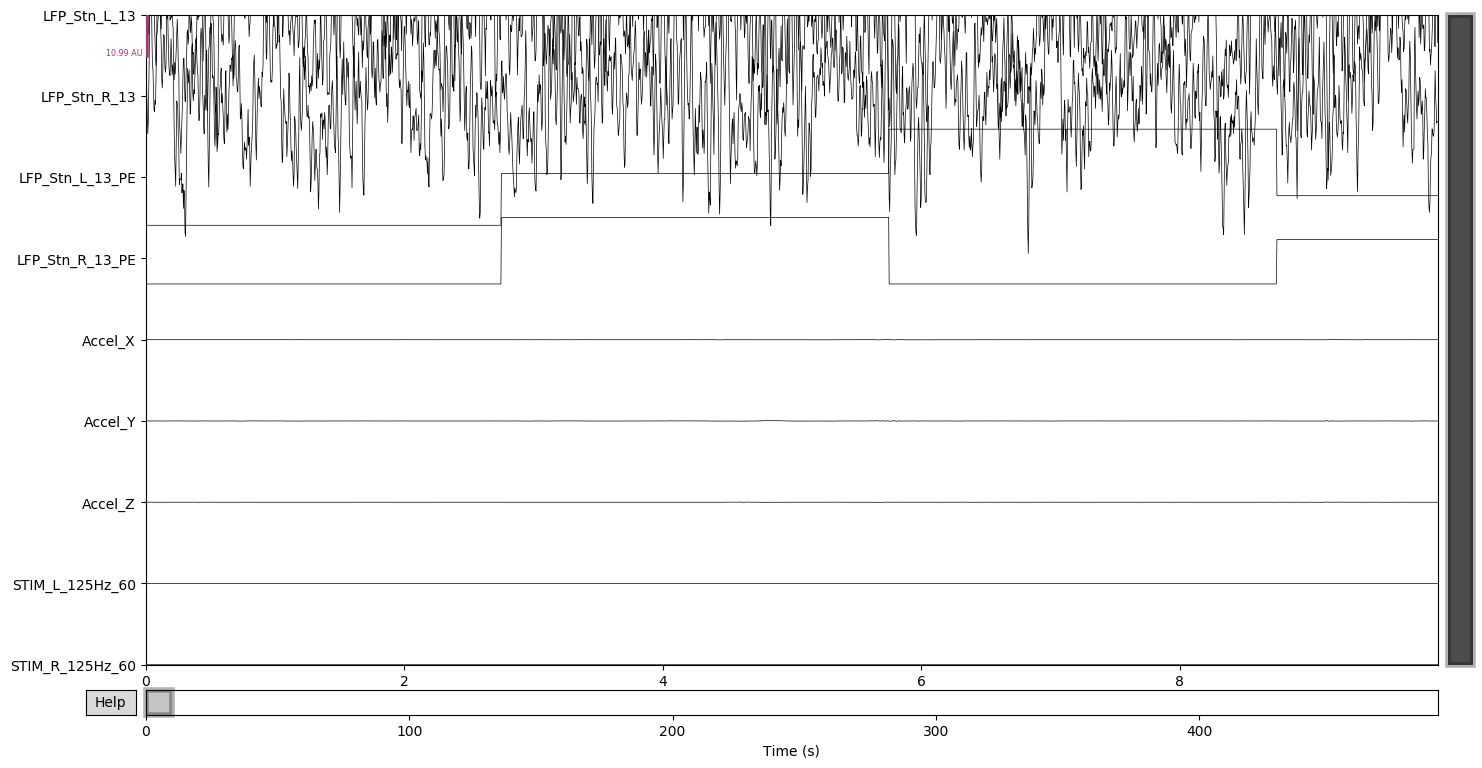

In [6]:
%matplotlib qt 
raw.plot()

In [260]:
#Interactive plot for artefact rejection
%matplotlib qt 

fig = raw.plot(n_channels = 2, highpass = 5, lowpass = 100, 
    filtorder = 5, duration = 20)


Setting up band-pass filter from 5 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 5.00, 100.00 Hz: -6.02, -6.02 dB



In [261]:
#First time making them
interactive_annot = raw.annotations
raw.annotations.save('Sub029_Bilateral_artefactsAnnotations.csv', 
    overwrite = True)

Channels marked as bad:
none


In [7]:
#Importing them later
interactive_annot = pd.read_csv(
    os.path.join(
        ftg_path,
        'data',
        'raw_data',
        'clean_fifs',
        'sub029',
        'Sub029_RampUpThres_artefactsAnnotations.csv'
    )
)

#fix timing in imported annotations
reload(fix_annot_onsets)
new_onsets = fix_annot_onsets.fix_annot_onsets(interactive_annot)
print(new_onsets)

[ 20.8  27.2  31.7  34.4  77.2  93.7 115.2 123.2 145.6 168.5 186.3 217.7
 228.6 317.1 350.8 357.8 366.1 451.3 477.8 480.3 482.3 484.3 487.4 489.3]


In [8]:
my_annot = mne.Annotations(onset=new_onsets,  # in seconds
                           duration=interactive_annot.duration,  # in seconds, too
                           description=interactive_annot.description,
                           orig_time=raw.info['meas_date'])

reload(mat2fif)
%matplotlib qt
new_raw = mat2fif.mat2fif(raw,my_annot)

Channels marked as bad: none
Omitting 4700 of 122625 (3.83%) samples, retaining 117925 (96.17%) samples.
Creating RawArray with float64 data, n_channels=9, n_times=117925
    Range : 0 ... 117924 =      0.000 ...   471.696 secs
Ready.


In [22]:
new_raw.ch_names


['LFP_Stn_L_13',
 'LFP_Stn_R_13',
 'LFP_Stn_L_13_PE',
 'LFP_Stn_R_13_PE',
 'STIM_L_125Hz_60',
 'STIM_R_125Hz_60',
 'Accel_X',
 'Accel_Y',
 'Accel_Z']

In [31]:
import matplotlib.patches as patches

In [80]:
%matplotlib qt
fig, axs = plt.subplots(2, figsize=(15, 15))

fig.suptitle('sub-029_ses-EphysMedOn01_task-RampUpThres125_acq-StimOnR2b_run-01')

ax2 = axs[1].twinx()
axs[0].plot(new_raw.times, new_raw.get_data(picks = 'Accel_Z')[0])

axs[1].specgram(x = new_raw.get_data(picks = 1)[0], Fs = 250, noverlap = 0.5, cmap = 'viridis',
                        vmin = -25, vmax = 10)
axs[1].set_ylim(bottom = 5,top = 100)
ax2.plot(new_raw.times, new_raw.get_data(picks = 'STIM_R_125Hz_60')[0]/3, 'w', linewidth = 1.5)
ax2.set_yticks(np.arange(0,4.5,1))
axs[1].set_yticks(np.arange(0,120,20))
ax2.set_ylabel('Stimulation Amplitude [mA]')
axs[1].set_ylabel('Frequency [Hz]')
axs[1].set_xlabel('Time [sec]')
axs[0].set_ylabel('Acceleration [m/S^2]')
rect1 = patches.Rectangle((220,1),20,100,facecolor = 'red', alpha = 0.2)
rect2 = patches.Rectangle((362,1),13,100,facecolor = 'red', alpha = 0.2)

rect3 = patches.Rectangle((241,1),12,100,facecolor = 'black', alpha = 0.3)
rect4 = patches.Rectangle((264,1),10,100,facecolor = 'black', alpha = 0.3)
rect5 = patches.Rectangle((285,1),15,100,facecolor = 'black', alpha = 0.3)
rect6 = patches.Rectangle((379,1),10,100,facecolor = 'black', alpha = 0.3)
rect7 = patches.Rectangle((399,1),12,100,facecolor = 'black', alpha = 0.3)
rect8 = patches.Rectangle((421,1),11,100,facecolor = 'black', alpha = 0.3)

axs[1].add_patch(rect1)
axs[1].add_patch(rect2)
axs[1].add_patch(rect3)
axs[1].add_patch(rect4)
axs[1].add_patch(rect5)
axs[1].add_patch(rect6)
axs[1].add_patch(rect7)
axs[1].add_patch(rect8)

matplotlib.rc('font', size=20)
#plt.plot(new_raw.times, new_raw.get_data(picks = 'STIM_R_125Hz_60')[0])

In [81]:
plt.savefig('sub-029_ses-EphysMedOn01_task-RampUpThres125_acq-StimOnR2b_run-01.pdf')

In [23]:
#Plot TF plot with artefact rejected data
%matplotlib qt
reload(dat_preproc)
x = raw.get_data(reject_by_annotation = 'omit',picks=[0,1])
raw = raw
win_samp = 250
noverlap = 0.5
window = hann(win_samp, sym=False)
f, t, Sxx = dat_preproc.fft_rawviz(raw, x, win_samp, noverlap)

In [36]:
(7*60) + 29

449

In [17]:
(((8*60)+10) - 41)

7.483333333333333

### Plot Power Spectra in epochs

In [ ]:
%matplotlib inline
stim_onsets = [1, 30, 110, 240]
labels = ['Ipsi_Stim','NoStim','Contra_Stim','Bilateral']
dur = 20

#for l in range(0,4):
    #plt.plot(np.mean(Sxx[1,:,stim_onsets[l]:stim_onsets[l]+dur],1), label = labels[l])
    #plt.xlim(40, 90)
    #plt.ylim(0,0.5)
tt, Pxx = scipy.signal.welch(Sxx[1,1:20], fs = 250, nperseg = 250, noverlap = 0.25)
plt.plot(np.arange(1,127), np.mean(Pxx[0],1), label = labels[l])

plt.legend(labels)

In [6]:
reload(dat_preproc)
x = new_raw.get_data() #getting only RSTN channel

x1 = x[1, 12500:75000] 

dat_subh = dat_preproc.low_highpass_filter(x1, 60, 65) #filtering for 60-65Hz
dat_ngam = dat_preproc.low_highpass_filter(x1, 82, 87) #filtering for 80-90Hz
dat_bet = dat_preproc.low_highpass_filter(x1, 20, 35) #filtering for 23-35Hz

datall = [dat_bet, dat_subh, dat_ngam] 
labels = ['High Beta [20-35Hz]', 'Subharmonic [60-65Hz]','FTG [82-87Hz]']

In [7]:
def window_rms(a, window_size):
  a2 = np.power(a,2)
  window = np.ones(window_size)/float(window_size)
  return np.sqrt(np.convolve(a2, window, 'valid'))

In [35]:
sm_signal_np.shape

(3, 60501)

In [37]:
sm_signal_np = np.empty(shape = (3, 61501))
sm_signal_np[:] = np.nan

fig, axes = plt.subplots(3, 1, figsize=(12, 5))
wintosmooth = 1000

for idx, dat in enumerate(datall):
    hiltr = hilbert(dat)
    amplitude_envelope = np.abs(hiltr)
    zscore_sign = stats.zscore(amplitude_envelope)

    print(zscore_sign.shape)
    sm_signal = window_rms(zscore_sign, wintosmooth)
    print(sm_signal.shape)
    
    axes[idx].plot(sm_signal)
    #plt.plot(np.arange(0,75000), amplitude_envelope, label = labels[idx]) 
    
    axes[idx].axvline(26250, color = 'b', ls='--', lw=2, label = 'Stim On')
    axes[idx].axvline(50250, color = 'g', ls='--', lw=2, label = 'Stim Off')
    axes[idx].set_ylabel(str(labels[idx])+ ' Env.')
    axes[idx].set_xlim([0, sm_signal.shape[0]])

    if idx == 1 or idx == 2:
        axes[idx].set_ylim(0,2)
    
    sm_signal_np[idx,:] = sm_signal

    #axes[idx].set_xticks(ticks = np.arange(0, 80000, 10000), labels = np.arange(0,320,40))
    plt.xlabel('Time [sec]')

    

plt.suptitle('Smoothing Window: 125 samples')
axes[0].legend(loc='upper right')

plt.show()

In [38]:
x2 = x[5, 12500:75000] 
sm_stim = window_rms(x2, wintosmooth)
sm_stim1 = (sm_stim + 1)/3

In [42]:
newlabs = ['High Beta [20-35Hz]','Subharmonic [60-65Hz]','FTG [82-87Hz]']
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for idx, dat in enumerate(sm_signal_np):
    ax1.plot(sm_signal_np[idx,:], label = newlabs[idx], lw = 2)
ax2.plot(sm_stim1, label = 'Stimulation', color = 'grey', ls='--', lw=3, alpha = 0.4)
ax1.legend()
ax1.set_ylabel('Z-scored Smoothed Analytic Signal')
ax2.set_ylabel('Stimulation Amplitude [mA]')
ax2.set_yticks(np.arange(0.5, 2.5, 0.25))
ax2.set_yticklabels(np.arange(0.25, 2.25, 0.25))
ax1.set_xlim(0, sm_signal_np.shape[0])
ax1.set_xticks(np.arange(0, 70000, 10000))
ax1.set_xticklabels(np.arange(0, 280, 40))
ax1.set_xlabel('Time [sec]')

plt.show()


In [ ]:
# let's explore some frequency bands
iter_freqs = [
    ('Beta', 13, 35),
    ('SubGamma', 60, 65),
    ('NarrGamma', 65, 90)
]

In [ ]:
new_raw.ch_names

In [ ]:
raw = new_raw
events = mne.find_events(raw, stim_channel='STIM_R_125Hz_60us')
print(events)

In [ ]:
# set epoching parameters
event_id, tmin, tmax = 1, -1., 3.
baseline = None


frequency_map = list()

for band, fmin, fmax in iter_freqs:
    # (re)load the data to save memory

    # bandpass filter
    raw.filter(fmin, fmax, n_jobs=None,  # use more jobs to speed up.
               l_trans_bandwidth=1,  # make sure filter params are the same
               h_trans_bandwidth=1, picks = 'LFP_Stn_R_13')  # in each band and skip "auto" option.

    # epoch
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=baseline,
                        picks= 'LFP_Stn_R_13',
                        preload=True)
    # remove evoked response

    # get analytic signal (envelope)
    epochs.apply_hilbert(envelope=True, picks = 'LFP_Stn_R_13')
    frequency_map.append(((band, fmin, fmax), epochs.average(picks = 'LFP_Stn_R_13')))
    del epochs
del raw

In [ ]:
np.sum(average.data, axis = 0).shape

In [ ]:
from mne.stats import bootstrap_confidence_interval

# Helper function for plotting spread
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x ** 2, axis=0)


# Plot
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.colormaps['winter_r'](np.linspace(0, 1, 3))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp1 = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp1, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(average.data, random_state=0,
                                                  stat_fun=stat_fun)
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-1000, 3000)
    ax.set_ylim(-50,50)

axes.ravel()[-1].set_xlabel('Time [ms]')